### Experimental Parameters

In [1]:
import numpy as np
import pickle as pkl
%matplotlib inline

proposal_rates = np.array([1/300, 1/120, 1/60, 1/30, 1/10, 1/5, 1/2])
n_trials = 3

### Setup JSON File

In [3]:
import sys
import json

# Create experimental parameters and write to JSON file
max_block_size = 50
TX_rate = 5

params = {'Block proposal rate parameter': 0,
 'Block size (txs)': max_block_size,
 'Duration (sec)': 0,
 'Transaction rate parameter': TX_rate, # 1 second
 'Fork choice rule': 'OHIE',
 'Network model': 'Decker-Wattenhorf',
 'Number of adversaries': 1,
 'Number of nodes': 100,
 'Probability of error in transaction confirmation': 0.01,
 'Transaction dataset': 'poisson',
 'Transaction scheduling rule': 'FIFO',
 'Logging enabled': True,
 'Longest chains': 10
         }

### Run experiments

In [4]:
import os, shutil, pprint, glob, csv

#os.chdir('/mnt/c/Users/Kelvin/Desktop/course_repo/Blockchain/blockchain-simulator/')

pp = pprint.PrettyPrinter()
os.system('touch OHIE.json')

sys.path.append("..") 

import metrics
import uuid

throughputs = {}
throughputs_unique = {}
main_chain_arrival_latencies = {}
finalization_latencies = {}

print(os.getcwd())
    
for i in range(0, len(proposal_rates)):
    rate = proposal_rates[i]
    params['Block proposal rate parameter'] = rate
    params['Duration (sec)'] = 50/rate
    d = {}
    d['setting-name'] = f'OHIE-test'
    d[f'OHIE-test'] = params
    print('Parameters:')
    pp.pprint(d)
    with open('OHIE.json', 'w+') as outfile:
        json.dump(d, outfile)
    throughputs[rate] = []
    throughputs_unique[rate] = []
    main_chain_arrival_latencies[rate] = []
    finalization_latencies[rate] = []
    for trial in range(0, n_trials):
        shutil.rmtree('../logs')
        os.system('python3 main.py -f OHIE.json')
        throughput, throughput_unique = metrics.compute_throughputs(foldername='../logs', filename='OHIE.json')
        avg_main_chain_arrival_latency, avg_finalization_latency = metrics.compute_latency(foldername='../logs')
        
        
        shutil.copytree('../logs', '../logs_{0}'.format(uuid.uuid4()) )
        
        throughputs[rate].append(throughput)
        throughputs_unique[rate].append(throughput_unique)
        main_chain_arrival_latencies[rate].append(avg_main_chain_arrival_latency)
        finalization_latencies[rate].append(avg_finalization_latency)

    
os.remove('OHIE.json')
print('Throughputs:\n', throughputs)
print('Unique Throughputs:\n', throughput_unique)
print('Main Chain Arrival Latencies:\n', main_chain_arrival_latencies)
print('Finalization Latencies:\n', finalization_latencies)

/home/makinohara/blockchain-simulator/results
Parameters:
{'OHIE-test': {'Block proposal rate parameter': 0.0033333333333333335,
               'Block size (txs)': 50,
               'Duration (sec)': 14999.999999999998,
               'Fork choice rule': 'OHIE',
               'Logging enabled': True,
               'Longest chains': 10,
               'Network model': 'Decker-Wattenhorf',
               'Number of adversaries': 1,
               'Number of nodes': 100,
               'Probability of error in transaction confirmation': 0.01,
               'Transaction dataset': 'poisson',
               'Transaction rate parameter': 5,
               'Transaction scheduling rule': 'FIFO'},
 'setting-name': 'OHIE-test'}
Parameters:
{'OHIE-test': {'Block proposal rate parameter': 0.008333333333333333,
               'Block size (txs)': 50,
               'Duration (sec)': 6000.0,
               'Fork choice rule': 'OHIE',
               'Logging enabled': True,
               'Longest 

### Compute Averages

Average main chain latency is the time for a transaction to be added to the global blocktree - the timestamp the transaction was created.

Average finalization latency is the time for a transaction to be k blocks deep - to be added to the global blocktree.

In [5]:
avg_main_chain_latencies = {}
for rate in main_chain_arrival_latencies:
    avg_main_chain_latencies[rate] = sum(main_chain_arrival_latencies[rate])/len(main_chain_arrival_latencies[rate])

print("Average Main Chain Arrival Latency:", avg_main_chain_latencies)
avg_finalization_latencies = {}
for rate in finalization_latencies:
    avg_finalization_latencies[rate] = sum(finalization_latencies[rate])/len(finalization_latencies[rate])
    
print("Average Finalization Latency:", avg_finalization_latencies)

avg_throughput = {}
for rate in throughputs:
    avg_throughput[rate] = sum(throughputs[rate])/len(throughputs[rate])
    
print("Average Throughput Latency:", avg_throughput)

avg_unique_throughput = {}
for rate in throughputs_unique:
    avg_unique_throughput[rate] = sum(throughputs_unique[rate])/len(throughputs_unique[rate])
    
print("Average Unique Throughput Latency:", avg_unique_throughput)

Average Main Chain Arrival Latency: {0.0033333333333333335: 0.0, 0.008333333333333333: 0.0, 0.016666666666666666: 0.0, 0.03333333333333333: 0.0, 0.1: 0.0, 0.2: 0.0, 0.5: 0.0}
Average Finalization Latency: {0.0033333333333333335: 0.0, 0.008333333333333333: 0.0, 0.016666666666666666: 0.0, 0.03333333333333333: 0.0, 0.1: 0.0, 0.2: 0.0, 0.5: 0.0}
Average Throughput Latency: {0.0033333333333333335: 0.0, 0.008333333333333333: 0.0, 0.016666666666666666: 0.0, 0.03333333333333333: 0.0, 0.1: 0.0, 0.2: 0.0, 0.5: 0.0}
Average Unique Throughput Latency: {0.0033333333333333335: 0.0, 0.008333333333333333: 0.0, 0.016666666666666666: 0.0, 0.03333333333333333: 0.0, 0.1: 0.0, 0.2: 0.0, 0.5: 0.0}


### Extract Finalization Depth and Delta for Blocks

In [6]:
import csv
with open('../logs/stats.csv', newline='') as csvfile:
    reader = csv.reader(csvfile, delimiter=',')
    for row in reader:
        if row[0]=='Finalization depth':
            k = int(row[1])
        elif row[0]=='Average network latency for blocks (sec)':
            delta = float(row[1])
print(delta)
print(k)


1.5833333333333335
2


In [8]:
OHIE_data = {}
OHIE_data['throughputs'] = throughputs
OHIE_data['throughputs_unique'] = throughputs_unique
OHIE_data['main_chain_arrival_latencies'] = main_chain_arrival_latencies
OHIE_data['finalization_latencies'] = finalization_latencies
OHIE_data['k'] = k
OHIE_data['delta'] = delta

pkl.dump(OHIE_data, open('OHIE-data.pkl', 'wb'))

In [7]:
# bitcoin_ng_data = pkl.load( open( "OHIE-data-final.pkl", "rb" ) )
# throughputs = bitcoin_ng_data['throughputs']
# throughputs_unique = bitcoin_ng_data['throughputs_unique']
# main_chain_arrival_latencies = bitcoin_ng_data['main_chain_arrival_latencies']
# finalization_latencies = bitcoin_ng_data['finalization_latencies']
# k = bitcoin_ng_data['k']
# delta = bitcoin_ng_data['delta']
# max_block_size = 50

### Plotting the results

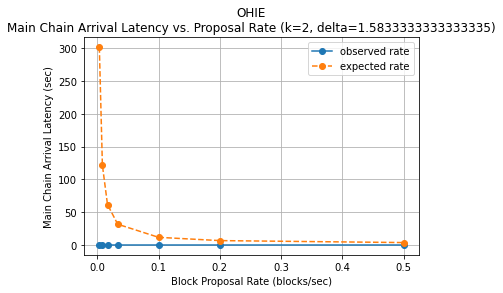

In [9]:
import matplotlib.pylab as plt
x = avg_main_chain_latencies.keys()
y1 = avg_main_chain_latencies.values()
expected_y1 = (delta+1.0/proposal_rates)
y2 = avg_finalization_latencies.values()
expected_y2 = k*(delta+1.0/proposal_rates)

y3 = avg_unique_throughput.values()
T = list(map(lambda x: min(x, max_block_size),  TX_rate/proposal_rates)) # transaction per block, 1 Tx per second / x blocks / sec = tx / block
expected_y3 = proposal_rates*T/(1+proposal_rates*delta)

plt.xlabel('Block Proposal Rate (blocks/sec)')
plt.ylabel('Main Chain Arrival Latency (sec)')
plt.title(f'OHIE\nMain Chain Arrival Latency vs. Proposal Rate (k={k}, delta={delta})')
plt.grid(True)

plt.plot(x, y1, 'o-', label='observed rate')
plt.plot(x, expected_y1, 'o--', label='expected rate')
plt.legend()
plt.show()

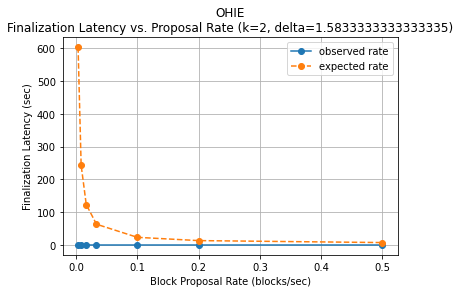

In [10]:
plt.xlabel('Block Proposal Rate (blocks/sec)')
plt.ylabel('Finalization Latency (sec)')
plt.title(f'OHIE\nFinalization Latency vs. Proposal Rate (k={k}, delta={delta})')
plt.grid(True)

plt.plot(x, y2, 'o-', label='observed rate')
plt.plot(x, expected_y2, 'o--', label='expected rate')
plt.legend()
plt.show()

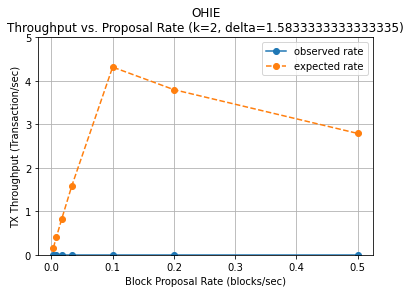

In [11]:
plt.xlabel('Block Proposal Rate (blocks/sec)')
plt.ylabel('TX Throughput (Transaction/sec)')
plt.title(f'OHIE\nThroughput vs. Proposal Rate (k={k}, delta={delta})')
plt.grid(True)


plt.plot(x, y3, 'o-', label='observed rate')
plt.plot(x, expected_y3, 'o--', label='expected rate')
plt.legend()
plt.ylim([0, TX_rate])
plt.show()